## **Task  1 - Práctica**
Para esta parte estarán resolviendo el problema de CartPole con Deep Q-Learning y una red de destino. Para esto, el
objetivo de este ejercicio es entrenar a un agente para que equilibre un poste en un carro (cartpole) en movimiento
durante el mayor tiempo posible. Se deberá usar Deep Q-Learning (DQL) con una red objetivo para lograr esto.


#### 1. librerias

In [ ]:
from collections import deque, namedtuple
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


#### 2. Entorno en Cartpole

In [2]:
np.random.seed(123)
torch.manual_seed(123)

env = gym.make("CartPole-v1", render_mode="rgb_array")
env


<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [3]:
obs, info = env.reset(seed=123)
obs_dim   = env.observation_space.shape[0]
action_dim= env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3. Definan las redes en línea y de destino:

Cree dos redes neuronales, la red en línea y la red de destino. La red
en línea se utiliza para la selección de acciones y se actualiza con más frecuencia, mientras que la red de
destino se utiliza para estimar los valores Q y se actualiza periódicamente. Ambas redes deberían tener una
arquitectura similar con capas de entrada y salida. Inicialmente, la red de destino debería tener los mismos
pesos que la red en línea.  

In [4]:
class QNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden=(128, 128)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden[0]),
            nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
            nn.Linear(hidden[1], action_dim)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

online_q = QNetwork(obs_dim, action_dim).to(device)
target_q = QNetwork(obs_dim, action_dim).to(device)

# target inicial
target_q.load_state_dict(online_q.state_dict())
for p in target_q.parameters():
    p.requires_grad = False
target_q.eval()

# Optimizador y loss
optimizer = optim.Adam(online_q.parameters(), lr=1e-3)
loss_fn   = nn.SmoothL1Loss()

# Sincronizacion de redes
def hard_update(target: nn.Module, source: nn.Module):
    target.load_state_dict(source.state_dict())

@torch.no_grad()
def soft_update(target: nn.Module, source: nn.Module, tau: float = 0.005):
    for tp, sp in zip(target.parameters(), source.parameters()):
        tp.data.mul_(1.0 - tau).add_(sp.data, alpha=tau)

#### 4. Establecer hiperparámetros
Defina hiperparámetros como el número de episodios, el tamaño de los
batches, el factor de descuento (gamma) y los parámetros de exploración (epsilon, epsilon decay, epsilon
mínimo). Ajuste estos hiperparámetros según sea necesario para optimizar el entrenamiento.


In [ ]:
from dataclasses import dataclass
import torch

@dataclass
class DQNConfig:
    episodes: int = 500
    buffer_capacity: int = 50_000
    warmup_steps: int = 5_000
    batch_size: int = 64
    gamma: float = 0.99
    lr: float = 1e-3

    # Exploracion
    epsilon_start: float = 1.0
    epsilon_end: float = 0.03
    epsilon_decay_steps: int = 15_000
    use_exponential_eps: bool = False

    # Target network
    target_update_every: int = 1_000
    use_soft_update: bool = False
    tau: float = 0.005

    grad_clip: float = 10.0
    seed: int = 123

cfg = DQNConfig()

def epsilon_linear(step: int, cfg: DQNConfig):
    frac = min(1.0, step / cfg.epsilon_decay_steps)
    return cfg.epsilon_start + (cfg.epsilon_end - cfg.epsilon_start) * frac

def epsilon_exponential(step: int, cfg: DQNConfig):
    decay = (cfg.epsilon_end / cfg.epsilon_start) ** (1.0 / cfg.epsilon_decay_steps)
    return max(cfg.epsilon_end, cfg.epsilon_start * (decay ** step))

def get_epsilon(global_step: int, cfg: DQNConfig):
    if cfg.use_exponential_eps:
        return epsilon_exponential(global_step, cfg)
    return epsilon_linear(global_step, cfg)

#### 5. selección de acciones épsilon-greedy
Cree una función para la selección de acciones épsilon greedy. Esta función ayuda al agente a elegir acciones basadas en la política épsilon-greedy.


In [6]:
@torch.no_grad()
def select_action(state_np: np.ndarray, online_q: nn.Module, action_dim: int, device: torch.device, epsilon: float):
    if np.random.rand() < epsilon:
        return np.random.randint(action_dim)
    s = torch.tensor(state_np, dtype=torch.float32, device=device).unsqueeze(0)
    q = online_q(s)
    return int(q.argmax(dim=1).item())


In [7]:
# prueba para verrificar que funcione, no hace entrenamiento
global_step = 0
state, _ = env.reset(seed=cfg.seed)
done = False
taken = []
for _ in range(10):
    eps = get_epsilon(global_step, cfg)
    a = select_action(state, online_q, action_dim, device, eps)
    taken.append((a, round(eps, 3)))
    state, reward, terminated, truncated, _ = env.step(a)
    done = terminated or truncated
    global_step += 1
    if done:
        state, _ = env.reset(seed=cfg.seed)

print("Acciones (a, eps) en 10 pasos de prueba:", taken)


Acciones (a, eps) en 10 pasos de prueba: [(0, 1.0), (0, 1.0), (1, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (0, 1.0), (1, 1.0), (1, 0.999), (0, 0.999)]


#### 6. Defina la reproducción de la experiencia (experience replay):
Implemente una función para la reproducción de la experiencia, que es una parte crucial de DQL. Esta función ayuda al agente a aprender de una memoria
de repetición y a estabilizar el entrenamiento.


In [ ]:
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

memory = ReplayBuffer(cfg.buffer_capacity)


#### 7. Ciclo de entrenamiento:
Cree un ciclo para el entrenamiento del agente. En cada episodio, el agente
interactúa con el entorno, recopila experiencias y actualiza sus valores Q mediante la repetición de experiencias (experience replay). La red de destino se actualiza cada N episodios


In [10]:
def compute_loss(batch, online_q, target_q, cfg, device):
    states = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
    actions = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    rewards = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    dones = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

    # Q(s,a)
    q_values = online_q(states).gather(1, actions)

    with torch.no_grad():
        next_q = target_q(next_states).max(1, keepdim=True)[0]
        target = rewards + cfg.gamma * (1 - dones) * next_q

    loss = loss_fn(q_values, target)
    return loss

returns = []
global_step = 0

for ep in range(cfg.episodes):
    state, _ = env.reset(seed=cfg.seed + ep)
    done = False
    total_reward = 0

    while not done:
        epsilon = get_epsilon(global_step, cfg)
        action = select_action(state, online_q, action_dim, device, epsilon)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        global_step += 1

        if len(memory) >= cfg.warmup_steps:
            batch = memory.sample(cfg.batch_size)
            loss = compute_loss(batch, online_q, target_q, cfg, device)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(online_q.parameters(), cfg.grad_clip)
            optimizer.step()

            # Actualizar target
            if cfg.use_soft_update:
                soft_update(target_q, online_q, cfg.tau)
            elif global_step % cfg.target_update_every == 0:
                hard_update(target_q, online_q)

    returns.append(total_reward)

    if (ep+1) % 10 == 0:
        avg = np.mean(returns[-10:])
        print(f"Episodio {ep+1}, Retorno Promedio (últimos 10): {avg:.1f}")


Episodio 10, Retorno Promedio (últimos 10): 21.6
Episodio 20, Retorno Promedio (últimos 10): 24.2
Episodio 30, Retorno Promedio (últimos 10): 25.6
Episodio 40, Retorno Promedio (últimos 10): 27.0
Episodio 50, Retorno Promedio (últimos 10): 22.9
Episodio 60, Retorno Promedio (últimos 10): 23.6
Episodio 70, Retorno Promedio (últimos 10): 20.7
Episodio 80, Retorno Promedio (últimos 10): 26.0
Episodio 90, Retorno Promedio (últimos 10): 23.3
Episodio 100, Retorno Promedio (últimos 10): 26.8
Episodio 110, Retorno Promedio (últimos 10): 22.2
Episodio 120, Retorno Promedio (últimos 10): 29.5
Episodio 130, Retorno Promedio (últimos 10): 27.9
Episodio 140, Retorno Promedio (últimos 10): 34.9
Episodio 150, Retorno Promedio (últimos 10): 28.8
Episodio 160, Retorno Promedio (últimos 10): 28.8
Episodio 170, Retorno Promedio (últimos 10): 25.6
Episodio 180, Retorno Promedio (últimos 10): 27.3
Episodio 190, Retorno Promedio (últimos 10): 32.1
Episodio 200, Retorno Promedio (últimos 10): 24.2
Episodio 

#### 8. Representar el entorno:
Para visualizar el progreso del entrenamiento del agente, use env.render() para
mostrar el entorno CartPole durante el entrenamiento. Asegúrese de llamar a env.close() al final para limpiar
el renderizado

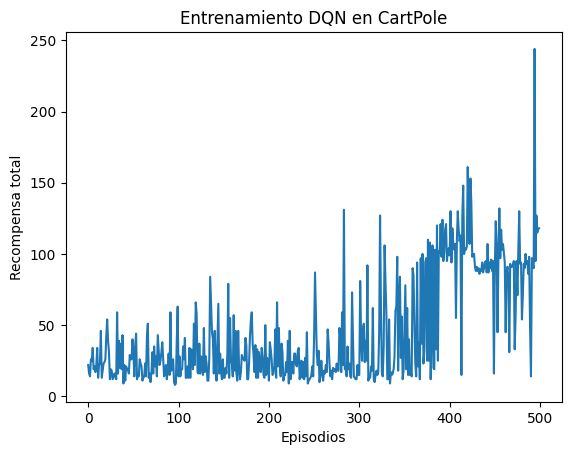

In [12]:
plt.plot(returns)
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Entrenamiento DQN en CartPole")
plt.show()


#### 9. Supervisar el entrenamiento:
Supervise el progreso del entrenamiento del agente, incluida la recompensa
total obtenida en cada episodio, para esto utilice una gráfica

In [13]:
def evaluate(env, online_q, episodes=10, render=False):
    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action = select_action(state, online_q, action_dim, device, epsilon=0.0)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward
            if render:
                env.render()
        total_rewards.append(ep_reward)
    return np.mean(total_rewards)

avg_reward = evaluate(env, online_q, episodes=10, render=False)
print(f"Recompensa promedio en evaluación: {avg_reward}")
env.close()


Recompensa promedio en evaluación: 102.3


#### 10. Evalúe el rendimiento:
Una vez que se complete el entrenamiento, evalúe el rendimiento del agente
probándolo en el entorno CartPole sin renderizar y observe qué tan bien puede equilibrar el poste.


## **Práctica 2 - Teoría**

Defina en qué consiste y en qué clase de problemas se pueden usar cada uno de los siguientes acercamientos en
Deep Reinforcement Learning.

---

### 1. Proximal Policy Optimization (PPO)

**¿En qué consiste?**  
- PPO es un método **on-policy** de optimización de políticas.  
- Busca un balance entre **mejorar la recompensa esperada** y **mantener la política actual cercana a la anterior**.  
- Introduce una **función de pérdida con un término de "clipping"** que evita actualizaciones muy grandes en los parámetros de la política, lo que ayuda a mantener la estabilidad.  
- Generalmente se implementa como **actor-critic**: el actor propone acciones y el crítico estima su valor.  

**Características clave:**  
- Simplicidad en la implementación.  
- Estable y confiable.  
- Menos costoso computacionalmente que TRPO, pero con resultados similares.  

**¿Dónde se usa?**  
- Juegos como **Atari**, **StarCraft II**, **Dota 2**.  
- Entornos de **control continuo en robótica**.

---

### 2. Deep Deterministic Policy Gradients (DDPG)

**¿En qué consiste?**  
- DDPG es un método **off-policy** y **actor-critic** para espacios de acción continuos.  
- El **actor** produce acciones determinísticas (no probabilísticas).  
- El **crítico** estima la función Q (valor esperado de una acción en un estado).  
- Usa un **replay buffer** para almacenar experiencias pasadas y entrenar con ellas, reduciendo la correlación de datos.  
- Utiliza **target networks suavizadas** para mejorar la estabilidad del entrenamiento.  

**Características clave:**  
- Adecuado para problemas de **alto control continuo**.  
- Puede aprender políticas muy precisas en tareas de control físico.  
- Puede ser inestable si no se ajustan bien los hiperparámetros.  

**¿Dónde se usa?**  
- Control de robots (ej. un brazo robótico que debe agarrar objetos).  
- Conducción autónoma.  
- Tareas de locomoción en simuladores 3D (ej. MuJoCo).  

---

### 3. Trust Region Policy Optimization (TRPO)

**¿En qué consiste?**  
- TRPO es un algoritmo **on-policy** basado en políticas.  
- En lugar de permitir actualizaciones arbitrarias de la política, **impone una restricción de confianza (trust region)**.  
- Esta restricción se mide con la **KL-divergence**, asegurando que la política nueva no se desvíe demasiado de la anterior.  
- Se enfoca en **estabilidad garantizada**, aunque a costa de más complejidad computacional.  

**Características clave:**  
- Muy estable en comparación con otros métodos.  
- Requiere resolver un problema de optimización más costoso.  
- Sirvió de base para el desarrollo de PPO.  

**¿Dónde se usa?**  
- Entornos de **robótica realista**, donde la estabilidad es crítica.  
- Tareas de control continuo donde un error drástico sería costoso.

---

### 4. Asynchronous Advantage Actor-Critic (A3C)

**¿En qué consiste?**  
- A3C es un método **actor-critic** que entrena **múltiples agentes en paralelo** (cada uno con una copia del entorno).  
- Cada agente actualiza de manera asíncrona los parámetros compartidos del modelo global.  
- Usa la ventaja (**$Advantage = Q(s,a) – V(s)$**) para reducir la varianza en el entrenamiento.  
- La paralelización acelera la exploración y evita caer en mínimos locales.  

**Características clave:**  
- Eficiente en términos de exploración y velocidad.  
- Reduce la correlación entre muestras al tener múltiples agentes explorando en paralelo.  
- Puede ser más inestable que PPO en algunos casos.  

**¿Dónde se usa?**  
- Juegos de Atari.  
- Entornos 3D complejos (ej. Doom, Minecraft).  
- Simulaciones con muchos estados posibles.  

---

### Tabla comparativa

| Algoritmo | Tipo | Idea principal | Ventajas | Limitaciones | Casos típicos |
|-----------|------|----------------|----------|--------------|---------------|
| **PPO** (Proximal Policy Optimization) | On-policy, Actor-Critic | Función de pérdida con *clipping* para limitar cambios bruscos en la política | Estable, eficiente, fácil de implementar | Menos muestra-eficiente que off-policy | Juegos (Atari, Dota2), robótica |
| **DDPG** (Deep Deterministic Policy Gradients) | Off-policy, Actor-Critic | Actor produce acciones continuas determinísticas, crítico evalúa con función Q, usa replay buffer | Maneja acciones continuas, buena precisión | Sensible a hiperparámetros, menos estable | Robótica, control autónomo, locomoción |
| **TRPO** (Trust Region Policy Optimization) | On-policy, Policy Gradient | Restringe la actualización de la política usando KL-divergence (trust region) | Muy estable, garantías teóricas | Computacionalmente costoso, difícil de implementar | Robótica avanzada, simulaciones físicas |
| **A3C** (Asynchronous Advantage Actor-Critic) | On-policy, Actor-Critic asíncrono | Entrena múltiples agentes en paralelo, cada uno explora y actualiza parámetros globales | Explora más rápido, menos correlación, eficiente | Puede ser inestable, reemplazado por PPO en muchos casos | Atari, videojuegos 3D, exploración compleja |

## Referencias

- DhanushKumar. (2025, agosto 11). PPO algorithm. Medium. https://medium.com/@danushidk507/ppo-algorithm-3b33195de14a

- Marekar, A. (2022, junio 12). How DDPG (Deep Deterministic Policy Gradient) Algorithms works in reinforcement learning ? Medium. https://medium.com/@amaresh.dm/how-ddpg-deep-deterministic-policy-gradient-algorithms-works-in-reinforcement-learning-117e6a932e68

- Sciforce. (2021, marzo 25). Reinforcement learning and Asynchronous Actor-Critic Agent (A3C) Algorithm, explained. Medium. https://medium.com/sciforce/reinforcement-learning-and-asynchronous-actor-critic-agent-a3c-algorithm-explained-f0f3146a14ab

- Wu, H. (2024, marzo 9). Trust Region Policy Optimization explained. Medium. https://medium.com/@hsinhungw/trust-region-policy-optimization-explained-c2671542c329